# Compare potentials

This Notebook uses the iprPy diatom scan calculation results to compare predictions across the different hosted potentials allowing for the determination of which potentials share interaction models.

In [53]:
from copy import deepcopy

import iprPy

import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path
from DataModelDict import DataModelDict as DM

import pandas as pd

## 1. Load results

In [10]:
database = iprPy.load_database('iprhub')
results_df = database.get_records_df(style='calculation_diatom_scan', status='finished')

In [ ]:
replacements = {}
replacements['AlS'] = 'Al'
replacements['CuS'] = 'Cu'
replacements['FeS'] = 'Fe'
replacements['MgS'] = 'Mg'
replacements['SiS'] = 'Si'
replacements['Id'] = 'I'

In [51]:
replacements = {}
replacements['AlS'] = 'Al'
replacements['CuS'] = 'Cu'
replacements['FeS'] = 'Fe'
replacements['MgS'] = 'Mg'
replacements['SiS'] = 'Si'
replacements['Id'] = 'I'

def interaction(series):
    elements = deepcopy(series.symbols)
    for i in range(len(elements)):
        if elements[i] in replacements:
            elements[i] = replacements[elements[i]]
        elif elements[i][0] in ['m']:
            return np.nan        
    
    return '-'.join(sorted(elements))

In [54]:
results_df['interaction'] = results_df.apply(interaction, axis=1)

In [58]:
results_df = results_df[results_df.interaction.notna()]

In [55]:
results_df.iloc[9]

key                                  0388a480-6d33-4fe1-849a-9758563873b1
iprPy_version                                                       0.9.1
atomman_version                                                   1.3.1.1
LAMMPS_version                                                 3 Mar 2020
script                                                   calc_diatom_scan
branch                                                               main
status                                                           finished
error                                                                 NaN
minimum_r                                                            0.02
maximum_r                                                              10
number_of_steps_r                                                     500
potential_LAMMPS_key                 b68a992d-faea-418e-b323-43c766e8a22e
potential_LAMMPS_id                      2004--Zhou-X-W--Pb--LAMMPS--ipr2
potential_key                        1

In [29]:
def diatom_comparison(series1, series2, rmin=1.5, rmax=4.0, rtol=1e-4):
    """
    Compares two diatom scan results on a point by point basis. The resulting
    value is the percentage of non-zero energy points between rmin and rmax
    that are within rtol of each other.
    """
    
    # Check that r values are the same
    r = series1.diatom_plot.r
    r2 = series2.diatom_plot.r
    assert len(r) == len(r2) and np.allclose(r, r2), 'series1 and series2 must have the same plot r values'
    
    # Get energies
    energy1 = series1.diatom_plot.energy
    energy2 = series2.diatom_plot.energy
    
    # Condition 1: Only consider points between rmin and rmax
    condition1 = (r >= rmin) & (r <= rmax)
    # Condition 2: Ignore points where both energies are zero
    condition2 = (energy1 != 0) | (energy2 != 0)
    c = condition1 & condition2
    
    # Count all points that correspond to the conditions
    allpoints = np.sum(c)
    
    # Return -100.0 to indicate no comparison could be made
    if allpoints == 0:
        return -100.0
    
    # Count the points with similar energies  
    matchpoints = np.sum(np.isclose(energy1[c] ,energy2[c], atol=0, rtol=rtol))

    # Return percentage of matchpoints out of allpoints
    return 100 * (matchpoints / allpoints)

In [482]:
# Select a potential and interaction
potential_id = '2008--Zhou-X-W-Zimmerman-J-A-Wong-B-M-Hoyt-J-J--Pd-H'
interaction = 'H-Pd'

Check: 10.227272727272728 2013--Hale-L-M-Wong-B-M-Zimmerman-J-A-Zhou-X-W--Pd-Ag-H-Morse


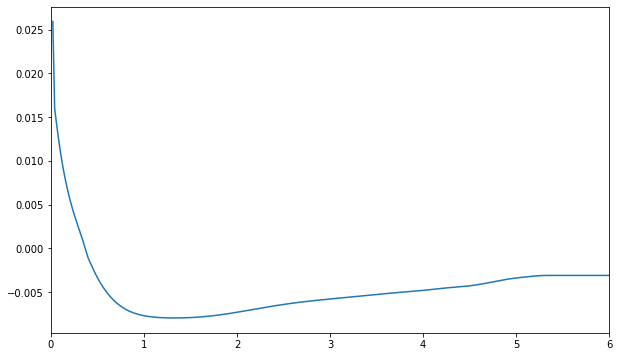

Check: 10.227272727272728 2013--Hale-L-M-Wong-B-M-Zimmerman-J-A-Zhou-X-W--Pd-Ag-H-Hybrid


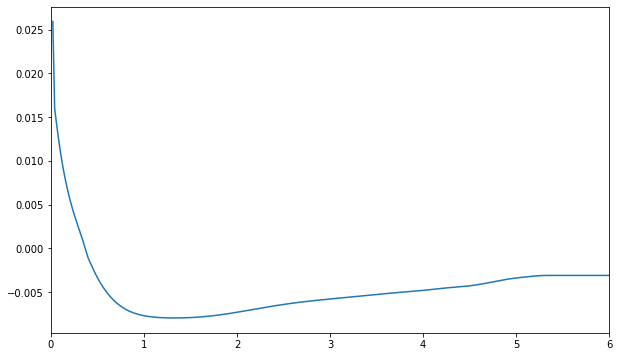

In [491]:
int_df = results_df[results_df.interaction == interaction]
same_df = int_df[int_df.potential_id == potential_id]
diff_df = int_df[int_df.potential_id != potential_id]

comps = {}
for i in same_df.index:
    series1 = int_df.loc[i]
    for j in diff_df.index:
        series2 = int_df.loc[j]
        pot_id = series2.potential_id
        if pot_id not in comps:
            comps[pot_id] = {}
            
        comparison = diatom_comparison(series1, series2, rmin=0.5, rtol=1e-3)
        if 'value' not in comps[pot_id] or comps[pot_id]['value'] < comparison:
            comps[pot_id]['value'] = comparison
            comps[pot_id]['i'] = i
            comps[pot_id]['j'] = j
        
for pot_id in comps:        
        
    print('Check:', comps[pot_id]['value'], pot_id)
    series1 = results_df.loc[comps[pot_id]['i']]
    series2 = results_df.loc[comps[pot_id]['j']]
    fig = plt.figure(figsize=(10,6))
    #plt.plot(series1.diatom_plot.r, series1.diatom_plot.energy)
    #plt.plot(series2.diatom_plot.r, series2.diatom_plot.energy, '--')
    plt.plot(series1.diatom_plot.r, series1.diatom_plot.energy - series2.diatom_plot.energy)
    plt.xlim(0.0, 6)
    #plt.ylim(-10, 10.0)
    plt.show()
    plt.close()
    

In [40]:
import json

In [44]:
with open('related-interactions.json') as f:
    relations = json.load(f)

In [45]:
relations.keys()

dict_keys(['Ag', 'Ag-Cu', 'Ag-Zr', 'Al', 'Al-Co', 'Al-Cu', 'Al-H', 'Al-Ni', 'Al-O', 'Al-Ti', 'Al-V', 'Au', 'C', 'C-Fe', 'C-Nb', 'C-Si', 'C-Ti', 'Ca', 'Ca-Mg', 'Cd', 'Cd-Te', 'Cd-Zn', 'Co', 'Co-Ni', 'Cr', 'Cr-Fe', 'Cr-Ni', 'Cu', 'Cu-H', 'Cu-Zr', 'Fe', 'Fe-Nb', 'Fe-Ni', 'Fe-Ti', 'Fe-W', 'Ga', 'Ga-In', 'Ga-N', 'H', 'H-Ni', 'H-Pd', 'H-V', 'In', 'In-N', 'Li', 'Mg', 'Mg-Zn', 'Mn', 'Mo', 'N', 'Nb', 'Ni', 'Ni-Ti', 'Ni-V', 'O', 'P', 'Pb', 'Pd', 'Pt', 'Si', 'Ta', 'Te', 'Te-Zn', 'Ti', 'U', 'V', 'W', 'Y', 'Zn', 'Zr'])

In [56]:
new = set()
for interaction in results_df.interaction:
    if interaction not in relations:
        new.add(interaction)
new

{'Ag-Al',
 'Ag-Au',
 'Ag-H',
 'Ag-Ni',
 'Ag-O',
 'Ag-Pd',
 'Ag-Pt',
 'Ag-Ta',
 'Al-Au',
 'Al-Cr',
 'Al-Fe',
 'Al-Mg',
 'Al-Mn',
 'Al-Nb',
 'Al-Pb',
 'Al-Pd',
 'Al-Pt',
 'Al-Si',
 'Al-Sm',
 'Al-U',
 'Al-Zn',
 'Ar',
 'Ar-Ne',
 'As',
 'As-Ga',
 'Au-Cd',
 'Au-Cu',
 'Au-Ni',
 'Au-Pd',
 'Au-Pt',
 'Au-Rh',
 'Au-Si',
 'B',
 'B-C',
 'B-N',
 'Ba',
 'Be',
 'Be-O',
 'Br',
 'Br-Cl',
 'Br-Cs',
 'Br-F',
 'Br-I',
 'Br-K',
 'Br-Li',
 'Br-Na',
 'Br-Rb',
 'C-Cu',
 'C-H',
 'C-Mn',
 'C-N',
 'C-O',
 'C-Pd',
 'C-Pt',
 'Ca-Cd',
 'Ca-Zn',
 'Cd-Hg',
 'Cd-S',
 'Cd-Se',
 'Ce',
 'Ce-O',
 'Cl',
 'Cl-Cs',
 'Cl-F',
 'Cl-I',
 'Cl-K',
 'Cl-Li',
 'Cl-Na',
 'Cl-Rb',
 'Co-Cr',
 'Co-Cu',
 'Co-Fe',
 'Co-Mn',
 'Co-Pd',
 'Co-Pt',
 'Co-Ti',
 'Co-V',
 'Cr-Cu',
 'Cr-Mn',
 'Cr-W',
 'Cs',
 'Cs-F',
 'Cs-I',
 'Cs-K',
 'Cs-Li',
 'Cs-Na',
 'Cs-Rb',
 'Cu-Fe',
 'Cu-Mg',
 'Cu-Mo',
 'Cu-N',
 'Cu-Ni',
 'Cu-Pb',
 'Cu-Pd',
 'Cu-Pt',
 'Cu-Si',
 'Cu-Ta',
 'Cu-Ti',
 'F',
 'F-I',
 'F-K',
 'F-Li',
 'F-Na',
 'F-Rb',
 'Fe-H',
 'Fe-Mg',
 'Fe-Mn',
 '

In [59]:
np.unique(results_df.interaction)

array(['Ag', 'Ag-Al', 'Ag-Au', 'Ag-Cu', 'Ag-H', 'Ag-Ni', 'Ag-O', 'Ag-Pd',
       'Ag-Pt', 'Ag-Ta', 'Ag-Zr', 'Al', 'Al-Au', 'Al-Co', 'Al-Cr',
       'Al-Cu', 'Al-Fe', 'Al-H', 'Al-Mg', 'Al-Mn', 'Al-Nb', 'Al-Ni',
       'Al-O', 'Al-Pb', 'Al-Pd', 'Al-Pt', 'Al-Si', 'Al-Sm', 'Al-Ti',
       'Al-U', 'Al-V', 'Al-Zn', 'Ar', 'Ar-Ne', 'As', 'As-Ga', 'Au',
       'Au-Cd', 'Au-Cu', 'Au-Ni', 'Au-Pd', 'Au-Pt', 'Au-Rh', 'Au-Si', 'B',
       'B-C', 'B-N', 'Ba', 'Be', 'Be-O', 'Br', 'Br-Cl', 'Br-Cs', 'Br-F',
       'Br-I', 'Br-K', 'Br-Li', 'Br-Na', 'Br-Rb', 'C', 'C-Cu', 'C-Fe',
       'C-H', 'C-Mn', 'C-N', 'C-Nb', 'C-O', 'C-Pd', 'C-Pt', 'C-Si',
       'C-Ti', 'Ca', 'Ca-Cd', 'Ca-Mg', 'Ca-Zn', 'Cd', 'Cd-Hg', 'Cd-S',
       'Cd-Se', 'Cd-Te', 'Cd-Zn', 'Ce', 'Ce-O', 'Cl', 'Cl-Cs', 'Cl-F',
       'Cl-I', 'Cl-K', 'Cl-Li', 'Cl-Na', 'Cl-Rb', 'Co', 'Co-Cr', 'Co-Cu',
       'Co-Fe', 'Co-Mn', 'Co-Ni', 'Co-Pd', 'Co-Pt', 'Co-Ti', 'Co-V', 'Cr',
       'Cr-Cu', 'Cr-Fe', 'Cr-Mn', 'Cr-Ni', 'Cr-W', 'Cs', 'Cs-F', 'Cs-I',
  

In [72]:
# Get all unique element interactions
interactions = np.unique(results_df.interaction)

In [429]:
ignores = ['2019--Mendelev-M-I--Cu-Zr', '2017--Wang-P-Xu-S-Liu-J-et-al--TWIP']

In [740]:
for interaction in interactions:
    if interaction not in relations:
        relations[interaction] = []
    relatedsets = relations[interaction]
    known = []
    for relatedset in relatedsets:
        for potential_id in relatedset:
            if potential_id in known:
                print(potential_id, 'listed in multiple sets')
            known.append(potential_id)

    interaction_df = results_df[results_df.interaction == interaction]

    unknown = []
    for potential_id in np.unique(interaction_df.potential_id):
        if potential_id not in known and potential_id not in ignores:
            unknown.append(potential_id)
    
    if len(unknown) == 0:
        continue
        
    print(interaction)
    for potential_id in unknown:
        print(potential_id)

        same_df = interaction_df[interaction_df.potential_id == potential_id]
        diff_df = interaction_df[interaction_df.potential_id != potential_id]

        comps = {}
        for i in same_df.index:
            series1 = results_df.loc[i]
            for j in diff_df.index:
                series2 = results_df.loc[j]
                pot_id = series2.potential_id
                if pot_id not in comps:
                    comps[pot_id] = {}

                comparison = diatom_comparison(series1, series2)
                if 'value' not in comps[pot_id] or comps[pot_id]['value'] < comparison:
                    comps[pot_id]['value'] = comparison
                    comps[pot_id]['i'] = i
                    comps[pot_id]['j'] = j

        for pot_id in comps:        

            if comps[pot_id]['value'] > 90:
                print('Match:', comps[pot_id]['value'], pot_id)
            elif comps[pot_id]['value'] > 10:
                print('Check:', comps[pot_id]['value'], pot_id)
                series1 = results_df.loc[comps[pot_id]['i']]
                series2 = results_df.loc[comps[pot_id]['j']]
                fig = plt.figure(figsize=(10,6))
                plt.plot(series1.diatom_plot.r, series1.diatom_plot.energy)
                plt.plot(series2.diatom_plot.r, series2.diatom_plot.energy)
                plt.xlim(1.0, 6)
                plt.ylim(-10, 10.0)
                plt.show()
                plt.close()
        print()
    break

In [739]:
for potid in unknown:
    relatedsets.append([potid])

In [717]:
relatedsets

[['2008--Hennig-R-G-Lenosky-T-J-Trinkle-D-R-et-al--Ti',
  '2016--Zhang-P-Trinkle-D-R--Ti-O'],
 ['2015--Ko-W-S-Grabowski-B-Neugebauer-J--Ni-Ti',
  '2017--Maisel-S-B-Ko-W-S-Zhang-J-L-et-al--V-Ni-Ti'],
 ['2006--Kim-Y-M-Lee-B-J-Baskes-M-I--Ti',
  '2008--Kim-Y-M-Lee-B-J--Ti-C',
  '2008--Kim-Y-M-Lee-B-J--Ti-N',
  '2008--Sa-I-Lee-B--Fe-Ti',
  '2009--Kim-H-K-Jung-W-S-Lee-B-J--Fe-Ti-C',
  '2016--Kim-Y-K-Kim-H-K-Jung-W-S-Lee-B-J--Al-Ti',
  '2016--Lee-E-Lee-K-R-Baskes-M-I-Lee-B-J--Ti-O',
  '2017--Kim-J-S-Seol-D-Ji-J-et-al--Pt-Ti',
  '2017--Kim-Y-K-Kim-H-K-Jung-W-S-Lee-B-J--Ni-Al-Ti',
  '2017--Kim-Y-K-Kim-H-K-Jung-W-S-Lee-B-J--Ni-Ti',
  '2018--Jeong-G-U-Park-C-S-Do-H-S-et-al--Pd-Ti',
  '2020--Oh-S-H-Seol-D-Lee-B-J--Co-Ti']]

In [423]:
del relatedsets[-1]

In [667]:
relatedsets.append(['1996--Jacobsen-K-W-Stoltze-P-Norskov-J-K--Al-Ag-Au-Cu-Ni-Pd-Pt',
                    '1996--Jacobsen-K-W-Stoltze-P-Norskov-J-K--Pt'])

In [718]:
relatedsets[1]

['2015--Ko-W-S-Grabowski-B-Neugebauer-J--Ni-Ti',
 '2017--Maisel-S-B-Ko-W-S-Zhang-J-L-et-al--V-Ni-Ti']

In [719]:
relatedsets[1].append('2019--Kavousi-S-Novak-B-R-Baskes-M-I-et-al--Ni-Ti')

In [215]:
relatedsets.append(['2006--Lee-B-J--Fe-C', '2009--Kim-H-K-Jung-W-S-Lee-B-J--Fe-Ti-C', '2010--Kim-H-K-Jung-W-S-Lee-B-J--Fe-Nb-C'])

In [497]:
relations['H-V'] = [['2011--Shim-J-H-Lee-Y-S-Fleury-E-et-al--V-H',
  '2013--Shim-J-H-Ko-W-S-Kim-K-H-et-al--V-Al-H',
  '2013--Shim-J-H-Ko-W-S-Kim-K-H-et-al--V-Ni-H']]

In [741]:
relations

{'Ag': [['1986--Foiles-S-M-Baskes-M-I-Daw-M-S--Ag',
   '1986--Foiles-S-M-Baskes-M-I-Daw-M-S--Ag-Au-Cu-Ni-Pd-Pt'],
  ['1989--Adams-J-B-Foiles-S-M-Wolfer-W-G--Ag',
   '1989--Adams-J-B-Foiles-S-M-Wolfer-W-G--Ag-Au-Cu-Ni-Pd-Pt'],
  ['2004--Zhou-X-W-Johnson-R-A-Wadley-H-N-G--Ag',
   '2004--Zhou-X-W-Johnson-R-A-Wadley-H-N-G--Cu-Ag-Au'],
  ['2006--Williams-P-L-Mishin-Y-Hamilton-J-C--Ag',
   '2006--Williams-P-L-Mishin-Y-Hamilton-J-C--Cu-Ag',
   '2009--Wu-H-H-Trinkle-D-R--Cu-Ag',
   '2013--Hale-L-M-Wong-B-M-Zimmerman-J-A-Zhou-X-W--Pd-Ag-H-Hybrid',
   '2013--Hale-L-M-Wong-B-M-Zimmerman-J-A-Zhou-X-W--Pd-Ag-H-Morse'],
  ['2003--Lee-B-J-Shim-J-H-Baskes-M-I--Ag',
   '2009--Kang-K-H-Sa-I-Lee-J-C-et-al--Cu-Ag',
   '2009--Kang-K-H-Sa-I-Lee-J-C-et-al--Cu-Zr-Ag',
   '2009--Kang-K-H-Sa-I-Lee-J-C-et-al--Zr-Ag'],
  ['1959--Girifalco-L-A-Weizer-V-G--Ag'],
  ['1987--Ackland-G-J-Tichy-G-Vitek-V-Finnis-M-W--Ag'],
  ['1996--Jacobsen-K-W-Stoltze-P-Norskov-J-K--Ag',
   '1996--Jacobsen-K-W-Stoltze-P-Norskov-J-K--Al

In [743]:
newrelations = {}
for interaction in sorted(relations):
    newrelations[interaction] = relations[interaction]

In [744]:
newrelations

{'Ag': [['1986--Foiles-S-M-Baskes-M-I-Daw-M-S--Ag',
   '1986--Foiles-S-M-Baskes-M-I-Daw-M-S--Ag-Au-Cu-Ni-Pd-Pt'],
  ['1989--Adams-J-B-Foiles-S-M-Wolfer-W-G--Ag',
   '1989--Adams-J-B-Foiles-S-M-Wolfer-W-G--Ag-Au-Cu-Ni-Pd-Pt'],
  ['2004--Zhou-X-W-Johnson-R-A-Wadley-H-N-G--Ag',
   '2004--Zhou-X-W-Johnson-R-A-Wadley-H-N-G--Cu-Ag-Au'],
  ['2006--Williams-P-L-Mishin-Y-Hamilton-J-C--Ag',
   '2006--Williams-P-L-Mishin-Y-Hamilton-J-C--Cu-Ag',
   '2009--Wu-H-H-Trinkle-D-R--Cu-Ag',
   '2013--Hale-L-M-Wong-B-M-Zimmerman-J-A-Zhou-X-W--Pd-Ag-H-Hybrid',
   '2013--Hale-L-M-Wong-B-M-Zimmerman-J-A-Zhou-X-W--Pd-Ag-H-Morse'],
  ['2003--Lee-B-J-Shim-J-H-Baskes-M-I--Ag',
   '2009--Kang-K-H-Sa-I-Lee-J-C-et-al--Cu-Ag',
   '2009--Kang-K-H-Sa-I-Lee-J-C-et-al--Cu-Zr-Ag',
   '2009--Kang-K-H-Sa-I-Lee-J-C-et-al--Zr-Ag'],
  ['1959--Girifalco-L-A-Weizer-V-G--Ag'],
  ['1987--Ackland-G-J-Tichy-G-Vitek-V-Finnis-M-W--Ag'],
  ['1996--Jacobsen-K-W-Stoltze-P-Norskov-J-K--Ag',
   '1996--Jacobsen-K-W-Stoltze-P-Norskov-J-K--Al

In [745]:
with open('related-interactions2.json', 'w') as f:
    json.dump(newrelations, f)